<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continuous_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression

In [0]:
# ======= Libraries =======

import math
import sys
import os
import time
os.environ["OMP_NUM_THREADS"] = "5" # export OMP_NUM_THREADS=5
os.environ["OPENBLAS_NUM_THREADS"] = "5" # export OPENBLAS_NUM_THREADS=5
os.environ["MKL_NUM_THREADS"] = "5" # export MKL_NUM_THREADS=5
os.environ["VECLIB_MAXIMUM_THREADS"] = "5" # export VECLIB_MAXIMUM_THREADS=5
os.environ["NUMEXPR_NUM_THREADS"] = "5" # export NUMEXPR_NUM_THREADS=5
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint, solve_ivp
# from torchdiffeq import odeint
from scipy.linalg import expm, qr
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
from tqdm.notebook import tqdm
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
# Reproducibility
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# ======= Function definitions =======

def load_tom_data(epsilon=1e-5):
    X = sio.loadmat("./lls_data/fanlinear.mat")["A"].toarray()
    theta_true = sio.loadmat("./lls_data/shepplogan.mat")["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    return X, theta_true, y

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    init_bound = 1.0/math.sqrt(p)
    theta_0 = np.array(init_bound*torch.FloatTensor(p).uniform_(-1, 1))

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    try:
        R_it = np.linalg.inv(R.T)
    except np.linalg.LinAlgError as err:
        # print(err)
        R_it = np.linalg.pinv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        loss = 0
        for i_batch in range(m):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def rel_residual(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return np.linalg.norm(X @ theta - y)/np.linalg.norm(y)
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        loss = 0
        y_full = np.zeros(n)
        X_full = np.zeros((n, p))
        for i_batch in range(m):
            y_full[b*i_batch:b*(i_batch+1)]     = y[i_batch]
            X_full[b*i_batch:b*(i_batch+1), :]  = X[i_batch]

        return np.linalg.norm(X_full @ theta - y_full)/np.linalg.norm(y_full)
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n* X.T @ (X @ theta - y)
    elif len(X.shape) == 3:
        m, b, p = Xs.shape
        n = b*m

        gradient = 0
        for i_batch in range(m):
            gradient += 1/n* X[i_batch].T @ (X[i_batch] @ theta - y[i_batch])
        return gradient
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def sgd_training(theta_0, theta_lstsq, Xs, ys, lr, N_epochs = N_epochs):
    m, b, p = Xs.shape
    n = b*m
    loss_sgd, grad_sgd, par_diff_sgd = [], [], []
    theta_t = theta_0
    for i_epoch in tqdm_notebook(range(N_epochs)):
        loss_sgd.append(loss(Xs, theta_t, ys))
        grad_sgd.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
        par_diff_sgd.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
        for i_batch in range(m):          
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

        sys.stdout.write('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')

    print('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')    
    return loss_sgd, grad_sgd, par_diff_sgd

def gd_training(theta_0, theta_lstsq, X, y, total_time, stepsize):
    n, p = X.shape
    loss_gd, grad_gd, par_diff_gd = [], [], []
    theta_t = theta_0
    N_steps = int(total_time/stepsize)
    for i_step in tqdm_notebook(range(N_steps)):
        loss_gd.append(loss(X, theta_t, y))
        grad_gd.append(np.linalg.norm(gradient(X, theta_t, y)))
        par_diff_gd.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
                  
        theta_t = theta_t - stepsize*gradient(X, theta_t, y)

        sys.stdout.write('\r'+f'🤖 GD. Loss {loss_gd[-1]:.3f}, Grad_norm {grad_gd[-1]:.3f}, relpardiff {par_diff_gd[-1]:.3f} after {i_step} step.')

    print('\r'+f'🤖 GD. Loss {loss_gd[-1]:.3f}, _gd_norm {grad_gd[-1]:.3f}, relpardiff {par_diff_gd[-1]:.3f} after {i_step} step.')    
    return loss_gd, grad_gd, par_diff_gd

def spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize, N_spl_steps = N_spl_steps):
    m, b, p = Xs.shape
    n = b*m
    loss_spl, grad_spl, par_diff_spl = [], [], []
    theta_t = theta_0 
    for i_step in tqdm_notebook(range(N_spl_steps)):       
        i_batch = i_step % m
        if i_batch == 0:
            loss_spl.append(loss(Xs, theta_t, ys))
            grad_spl.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
            par_diff_spl.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
            sys.stdout.write('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} epoch. Stepsize {stepsize}')

        theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], stepsize, n)
    
    print('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} steps. Stepsize {stepsize}')
    return loss_spl, grad_spl, par_diff_spl

def plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, title = 'Linear least squares. Random'):
    colors = ['r', 'g', 'b']
    color_labels = ['^', 'o', '-']
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))
    fig.suptitle(title)
    for time, loss, grad, rel_diff, label, col, col_lab in zip(times, losses, grads, rel_diffs, labels, colors, color_labels):
        ax1.semilogy(time, loss,     col+col_lab, label = label)
        ax1.semilogy(time, loss,     col+':')
        ax2.semilogy(time, grad,     col+col_lab, label = label)
        ax2.semilogy(time, grad,     col+':')
        ax3.semilogy(time, rel_diff, col+col_lab, label = label)
        ax3.semilogy(time, rel_diff, col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title(r'$f(\theta(t))$')
    ax1.set_xlabel('t')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title(r'$\|\nabla f(\theta(t))\|$')
    ax2.set_xlabel('t')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title(r'$\frac{\|\theta(t) - \theta_{LS}\|}{\|\theta_{LS}\|}$')
    ax3.set_xlabel('t')
    plt.legend()
    fig.tight_layout()
    # plt.savefig(title + '.pdf')
    plt.show()

In [29]:
# ======= Problem generation =======

# We fix best learning rate for the SGD and try different hs for the splitting. 
# Drawing 3 graphs in cont time (loss, grad_norm, norm of theparameter difference)

p = 400
n = 2000
m = 100
b = 20
epsilon = 1e-1

LEARNING_RATE = 10**(-1.5)
N_epochs = 10
h = LEARNING_RATE*m # with this values we have equal number of epochs
# h = 10
TOTAL_TIME = N_epochs*LEARNING_RATE*m
GF_STEPSIZE   = 1e-4

N_spl_epochs = int(np.floor(TOTAL_TIME/h))
N_spl_steps  = N_spl_epochs*m

LABELS = ['SGD', 'Splitting I']
ts_sgd = np.linspace(0, TOTAL_TIME, int(N_epochs))
ts_spl = np.linspace(0, N_spl_epochs*h, N_spl_epochs)
ts_gd  = np.linspace(0, TOTAL_TIME, int(TOTAL_TIME/GF_STEPSIZE))

# problems = ['tomography', 'random']
# problems = ['tomography']
problems = ['random']

X, theta_0, y, theta_lstsq = generate_problem(p, n, lstsq=True, epsilon = epsilon)
Xs = np.zeros((m, b, p))
ys = np.zeros((m, b))
Qs = np.zeros((m, p, b))
Rs = np.zeros((m, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(m):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

loss_sgd, grad_sgd, par_diff_sgd = sgd_training(theta_0, theta_lstsq, Xs, ys, lr = LEARNING_RATE, N_epochs = N_epochs)
loss_spl, grad_spl, par_diff_spl = spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize = h, N_spl_steps = N_spl_steps)
loss_gd, grad_gd, par_diff_gd    = gd_training(theta_0,  theta_lstsq, X, y, total_time = TOTAL_TIME, stepsize = GF_STEPSIZE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


🤖 SGD. Loss 0.011, Grad_norm 0.066, relpardiff 0.003 after 9 epoch. Lr 0.03162277660168379
🤖 SGD. Loss 0.011, Grad_norm 0.066, relpardiff 0.003 after 9 epoch. Lr 0.03162277660168379


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


🤖 Splitting I. Loss 0.010, Grad_norm 0.047, relpardiff 0.002 after 900 epoch. Stepsize 3.162277660168379
🤖 Splitting I. Loss 0.010, Grad_norm 0.047, relpardiff 0.002 after 999 steps. Stepsize 3.162277660168379


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


🤖 GD. Loss 220.764, Grad_norm 15.748, relpardiff 0.768 after 2689 step.

KeyboardInterrupt: ignored

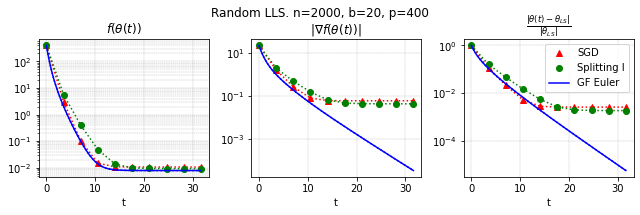

In [0]:
times     = [ts_sgd, ts_spl, ts_gd]
losses    = [loss_sgd, loss_spl, loss_gd]
grads     = [grad_sgd, grad_spl, grad_gd]
rel_diffs = [par_diff_sgd, par_diff_spl, par_diff_gd]
labels    = ['SGD', 'Splitting I', 'GF Euler']
title     = f'Random LLS. n={n}, b={b}, p={p}'
plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, title)

# Logistic regression

In [0]:
# ======= Function definitions =======

def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False, number_of_classes = 2):
    '''
    Load batches of MNIST data.

    Output: X_trains - m_train batches of training data, 
            y_trains - m_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (m_train,batch_size,*X_train[0].shape),
        where 
        m_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (m_train, K, batch_size),
        where
        K - the number of classes in the problem;

    X_test: torch.array of shape (n_test,*X_train[0].shape),
        where
        n_test - the number of test points;

    y_test: torch.array of shape (K, n_test);
    '''
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.train_data.to(dtype=torch.float)/255
    y_train = trainset.train_labels
    mask    = y_train < number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.MNIST('./mnist_data/', download=True, train=False)
    X_test = testset.test_data.to(dtype=torch.float)/255
    y_test = testset.test_labels
    mask   = y_test < number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    n_train = len(y_train)
    n_test  = len(y_test)

    m_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((m_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((m_train, batch_size), requires_grad=False).to(device)
    if qr_mode:
        Qs      = torch.zeros((m_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((m_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    for i in range(m_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        y_trains[i] = y_train[batch_size*i:batch_size*(i+1)]
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].t())      
    
    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def full_problem_from_batches(Xs, ys):
    m_train, batch_size, p = Xs.shape
    X = torch.zeros(m_train*batch_size, p)
    y = torch.zeros(m_train*batch_size)
    for i_batch in range(m_train):
        X[batch_size*i_batch:batch_size*(i_batch+1), :] = Xs[i_batch]
        y[batch_size*i_batch:batch_size*(i_batch+1)]    = ys[i_batch]
    return X, y

def model_init(model, parameters_tensor):
    new_model = copy.deepcopy(model)
    for parameter in new_model.parameters():
        parameter.data = parameters_tensor.clone().to(device)
        # We won't update bias during the training, since they are not affect the model predictions
        break
    return new_model

def gradient_flow_euler_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, total_time):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    n_train, p  = X.shape
    n_test      = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0
    model = model_init(model, theta_0.T)
    N_steps = int(total_time/lr)
    for i_step in range(N_steps):    
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)
        # Metrics
        model.eval()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        thetas.append(theta_t)
        losses_train.append(loss.data)
        pred_labels     = torch.squeeze(y_pred >= 0.5).float()
        train_acc       = y.eq(pred_labels.data).sum().to(dtype=torch.float)/len(pred_labels)
        errors_train.append(1 - train_acc) 
        y_pred_test = model(X_test)
        loss_test   = criterion(y_pred_test, y_test.float())
        losses_test.append(loss_test.data)
        pred_labels_test    = torch.squeeze(y_pred_test >= 0.5).long()
        test_acc            = y_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(y_pred_test)
        errors_test.append(1 - test_acc)
        sys.stdout.write('\r'+f'🤖 GD error {errors_test[-1]:.3f} on {i_step}-th iteration. Lr {lr}')
        # Backward pass 
        model.train()
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array((parameter.data.T).cpu())
            break
    
    print(f'\n🤖 GD finished with {N_steps} iterations on lr {lr}')

    return thetas, losses_train, losses_test, errors_train, errors_test

def sgd_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, N_epochs):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    m_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    n_test   = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0
    model = model_init(model, theta_0.t())
    for i_epoch in range(N_epochs):      
        for i_batch in range(m_train):    
            if i_batch == 0:
                # Evaluation pass
                model.eval()
                y_pred = model(X)
                loss = criterion(y_pred, y)
                thetas.append(theta_t)
                losses_train.append(loss.data)
                pred_labels     = torch.squeeze(y_pred >= 0.5).float()
                train_acc       = y.eq(pred_labels.data).sum().to(dtype=torch.float)/len(pred_labels)
                errors_train.append(1 - train_acc) 
                y_pred_test = model(X_test)
                loss_test   = criterion(y_pred_test, y_test.float())
                losses_test.append(loss_test.data)
                pred_labels_test    = torch.squeeze(y_pred_test >= 0.5).long()
                test_acc            = y_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(y_pred_test)
                errors_test.append(1 - test_acc)
                sys.stdout.write('\r'+f'🤖 SGD error {errors_test[-1]:.3f} on {i_epoch}-th epoch. Lr {lr}')

            # Backward pass
            model.train()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_trains[i_batch])
            loss = criterion(y_pred, y_trains[i_batch])
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array((parameter.data.t()).cpu())
                break
    
    print(f'\n🤖 SGD finished with {N_epochs} epochs on lr {lr}')

    return thetas, losses_train,losses_test, errors_train, errors_test

def make_splitting_step(theta_0, Q, R, y, h, n):
    h_seq = [0, h]
    Q, R, theta_0 = np.array(Q), np.array(R), np.array(theta_0)
    eta_0, theta_0 = np.squeeze(Q.T@theta_0), np.squeeze(theta_0)
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return torch.from_numpy(theta).reshape(p, 1)

def spl_training(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, stepsize, N_spl_steps, model):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_trains, y_trains, X_test, y_test, model = X.float().to(device), y.float().to(device), X_trains.float().to(device), y_trains.float().to(device), X_test.float().to(device), y_test.float().to(device), model.to(device)
    m_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    n_test      = len(y_test)
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = torch.nn.BCELoss()
    theta_t         = theta_0.to(device)
    model = model_init(model, theta_0.t())
    for i_step in range(N_spl_steps):         
        i_batch = i_step % m_train

        if i_batch == 0:      
            # Evaluation pass
            model.eval()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels     = torch.squeeze(y_pred >= 0.5).float()
            train_acc       = y.eq(pred_labels.data).sum().to(dtype=torch.float)/len(pred_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test = model(X_test)
            loss_test   = criterion(y_pred_test, y_test)
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.squeeze(y_pred_test >= 0.5).float()
            test_acc            = y_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(y_pred_test)
            errors_test.append(1 - test_acc)
            sys.stdout.write('\r'+f'🤖 Splitting error {errors_test[-1]:.3f} on {i_step}-th step. Stepsize {stepsize}')

        # Backward pass
        model.train()
        theta_t = make_splitting_step(theta_t.cpu(), Qs[i_batch].cpu(), Rs[i_batch].cpu(), y_trains[i_batch].cpu(), stepsize, n_train).to(dtype=torch.float)
        model = model_init(model, theta_t.t())

    print(f'\n🤖 Splitting finished with {N_spl_steps} iterations on Stepsize {stepsize}')

    return thetas, losses_train, losses_test, errors_train, errors_test

def plot_continuous_time_logreg(times, losses_trains, losses_tests, errors_trains, errors_tests, labels, title = 'LogReg. MNIST 0,1'):
    colors = ['r', 'g', 'b']
    color_labels = ['^', 'o', '-']
    fig, axs = plt.subplots(2, 2, figsize = (7,7))
    ax1, ax2, ax3, ax4 = [ax for row in axs for ax in row]
    fig.suptitle(title)
    for time, losses_train, losses_test, errors_train, errors_test, label, col, col_lab in zip(times, losses_trains, losses_tests, errors_trains, errors_tests, labels, colors, color_labels):
        ax1.semilogy(time, losses_train, col+col_lab, label = label)
        ax1.semilogy(time, losses_train, col+':')
        ax2.semilogy(time, errors_train, col+col_lab, label = label)
        ax2.semilogy(time, errors_train, col+':')
        ax3.semilogy(time, losses_test,  col+col_lab, label = label)
        ax3.semilogy(time, losses_test,  col+':')
        ax4.semilogy(time, errors_test,  col+col_lab, label = label)
        ax4.semilogy(time, errors_test,  col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title('Train loss')
    ax1.set_xlabel('t')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title('Train error')
    ax2.set_xlabel('t')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title('Test loss')
    ax3.set_xlabel('t')
    ax4.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax4.set_title('Test error')
    ax4.set_xlabel('t')
    plt.legend()
    fig.tight_layout()
    plt.savefig(title + '.pdf')
    plt.show()

In [181]:
BATCH_SIZE = 50
LEARNING_RATE = 1e-1

X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=BATCH_SIZE, shuffle = True, qr_mode = True, number_of_classes=2)
m_train, BATCH_SIZE, p = X_trains.shape # Yes, here we have bs the same as input parameter in the previous line.
n_train, n_test = m_train*BATCH_SIZE, len(y_test)

N_epochs = 10
h = LEARNING_RATE*m_train # with this values we have equal number of epochs
# h = 10
TOTAL_TIME = N_epochs*LEARNING_RATE*m_train
GF_STEPSIZE   = 1e-2

N_spl_epochs = int(np.floor(TOTAL_TIME/h))
N_spl_steps  = N_spl_epochs*m_train

LABELS = ['SGD', 'Splitting I', 'GF Euler']
ts_sgd = np.linspace(0, TOTAL_TIME, int(N_epochs))
ts_spl = np.linspace(0, N_spl_epochs*h, N_spl_epochs)
ts_gd  = np.linspace(0, TOTAL_TIME, int(TOTAL_TIME/GF_STEPSIZE))

print('🐱 Data loaded')

model = LogisticRegression()

print('🐱 Model loaded')
# Random initialization
# init_bound = 1.0/math.sqrt(p)
# theta_0 = init_bound*torch.FloatTensor(p, 1).uniform_(-1, 1)

# thetas_gd, losses_train_gd, losses_test_gd, errors_train_gd, errors_test_gd = \
#     gradient_flow_euler_training(theta_0, X_trains, y_trains, X_test, y_test, lr = GF_STEPSIZE, model=model, total_time=TOTAL_TIME)

thetas_sgd, losses_train_sgd, losses_test_sgd, errors_train_sgd, errors_test_sgd = \
    sgd_training(theta_0, X_trains, y_trains, X_test, y_test, lr=LEARNING_RATE, model=model, N_epochs=N_epochs)

thetas_spl, losses_train_spl, losses_test_spl, errors_train_spl, errors_test_spl = \
    spl_training(theta_0, Qs, Rs, X_trains, y_trains, X_test, y_test, stepsize=h, N_spl_steps = N_spl_steps, model=model)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


🤖QR started
✅QR computed
🐱 Data loaded
🐱 Model loaded
🤖 SGD error 0.606 on 0-th epoch. Lr 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([12650])) that is different to the input size (torch.Size([12650, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([2115])) that is different to the input size (torch.Size([2115, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


🤖 SGD error 0.000 on 9-th epoch. Lr 0.1
🤖 SGD finished with 10 epochs on lr 0.1
🤖 Splitting error 0.000 on 2277-th step. Stepsize 25.3
🤖 Splitting finished with 2530 iterations on Stepsize 25.3


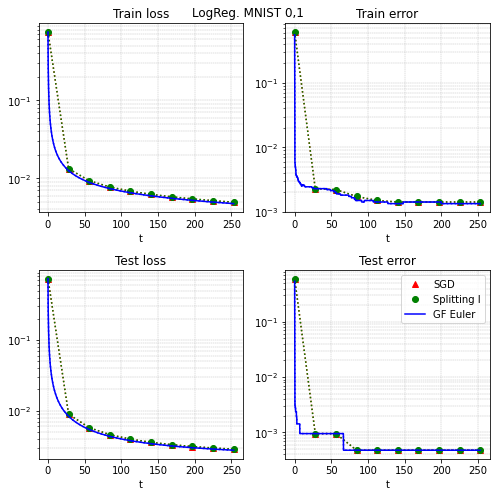

In [187]:
times         = [ts_sgd,           ts_spl,           ts_gd]
losses_trains = [losses_train_sgd, losses_train_spl, losses_train_gd[:-1]]
losses_tests  = [losses_test_sgd,  losses_test_spl,  losses_test_gd[:-1]]
errors_trains = [errors_train_sgd, errors_train_spl, errors_train_gd[:-1]]
errors_tests  = [errors_test_sgd,  errors_test_spl,  errors_test_gd[:-1]]
title     = 'LogReg. MNIST 0,1'

plot_continuous_time_logreg(times, losses_trains, losses_tests, errors_trains, errors_tests, LABELS, title = 'LogReg. MNIST 0,1')

# Softmax regression

In [0]:
# ======= Function definitions =======

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False, number_of_classes = 3):
    '''
    Load batches of MNIST data.

    Output: X_trains - s_train batches of training data, 
            y_trains - s_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (s_train,batch_size,*X_train[0].shape),
        where 
        s_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (s_train, K, batch_size),
        where
        K - the number of classes in the problem;

    X_test: torch.array of shape (n_test,*X_train[0].shape),
        where
        n_test - the number of test points;

    y_test: torch.array of shape (K, n_test);
    '''
    trainset = datasets.FashionMNIST('./fashion_mnist_data/', download=True, train=True)
    X_train = trainset.train_data.to(dtype=torch.float)/255
    y_train = trainset.train_labels
    mask    = y_train < number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.FashionMNIST('./fashion_mnist_data/', download=True, train=False)
    X_test = testset.test_data.to(dtype=torch.float)/255
    y_test = testset.test_labels
    mask   = y_test < number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    n_train = len(y_train)
    n_test  = len(y_test)

    s_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((s_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((s_train, K, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((s_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((s_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    y_test_one_hot = torch.zeros((n_test, K))
    y_test_one_hot[np.arange(n_test), y_test] = 1
    y_test_one_hot = y_test_one_hot.t()

    for i in range(s_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        batch_lbls  = y_train[batch_size*i:batch_size*(i+1)]
        y_batch_one_hot = torch.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), batch_lbls] = 1
        y_trains[i] = y_batch_one_hot.t()
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].t())      

    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test_one_hot, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test_one_hot

def load_batched_data_cifar(batch_size=50, shuffle = True, qr_mode = False, number_of_classes = 3):
    '''
    Load batches of CIFAR10 data.

    Output: X_trains - s_train batches of training data, 
            y_trains - s_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (s_train,batch_size,*X_train[0].shape),
        where 
        s_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (s_train, K, batch_size),
        where
        K - the number of classes in the problem;

    X_test: torch.array of shape (n_test,*X_train[0].shape),
        where
        n_test - the number of test points;

    y_test: torch.array of shape (K, n_test);
    '''
    trainset = datasets.CIFAR10('./cifar_data/', download=True, train=True)
    X_train = torch.from_numpy(trainset.train_data).to(dtype=torch.float)/255
    y_train = torch.Tensor(trainset.train_labels)
    mask    = y_train < number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.CIFAR10('./cifar_data/', download=True, train=False)
    X_test = torch.from_numpy(testset.test_data).to(dtype=torch.float)/255
    y_test = torch.Tensor(testset.test_labels)
    mask   = y_test < number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    n_train = len(y_train)
    n_test  = len(y_test)

    s_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((s_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((s_train, K, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((s_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((s_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    y_test_one_hot = torch.zeros((n_test, K))
    y_test_one_hot[np.arange(n_test), y_test.long()] = 1
    y_test_one_hot = y_test_one_hot.t()

    for i in range(s_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        batch_lbls  = y_train[batch_size*i:batch_size*(i+1)]
        y_batch_one_hot = torch.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), batch_lbls.long()] = 1
        y_trains[i] = y_batch_one_hot.t()
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].t())      

    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test_one_hot, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test_one_hot

def softmax_numpy(X):
    return np.array([np.exp(x)/sum(np.exp(x)) for x in X.T]).T

class CrossEntropyLoss_one_hot(nn.CrossEntropyLoss):
    '''
    Slightly modified version of the original CrossEntropyLoss in order to
    handle one-hot encodings
    '''
    def forward(self, input, target):
        target = torch.squeeze(torch.max(target, 1, keepdim=True)[1])
        return F.cross_entropy(input, target, weight=self.weight,
                                ignore_index=self.ignore_index, reduction=self.reduction)

def full_problem_from_batches(Xs, ys):
    s_train, batch_size, p = Xs.shape
    s_train, K, batch_size = ys.shape
    X = torch.zeros(s_train*batch_size, p)
    y = torch.zeros(K, s_train*batch_size)
    for i_batch in range(s_train):
        X[batch_size*i_batch:batch_size*(i_batch+1), :] = Xs[i_batch]
        y[:, batch_size*i_batch:batch_size*(i_batch+1)] = ys[i_batch]
    return X, y

def model_init(model, parameters_tensor):
    new_model = copy.deepcopy(model)
    for parameter in new_model.parameters():
        parameter.data = parameters_tensor.clone().to(device)
        # We won't update bias during the training, since they are not affect the model predictions
        break
    return new_model

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return F.softmax(self.linear(x), dim=1)

def load_model(X_test, y_test):
    '''
    Returns logistic regression model
    Which is just single linear layer with flattening at the beginning and softmax at the end
    '''
    input_dim = X_test[0].numel()
    K, n_test = y_test.shape

    model = LogisticRegression(input_dim, K)
    return model

def gradient_flow_euler_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, total_time):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    model = model_init(model, theta_0.T)
    N_steps = int(total_time/lr)
    for i_step in tqdm(range(N_steps)):  
        if i_step % SKIP_RATE == 0:
            model.eval() 
            # Forward pass
            y_pred = model(X)
            loss = criterion(y_pred, y.T)
            # Metrics
            y_pred = model(X)
            loss = criterion(y_pred, y.T)
            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
            true_labels         = torch.max(y.T, 1, keepdim=True)[1]
            train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test         = model(X_test)
            loss_test           = criterion(y_pred_test, y_test.T)
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
            true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
            test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
            errors_test.append(1 - test_acc)
            sys.stdout.write('\r'+f'🤖 GD error {errors_test[-1]:.3f} on {i_step}-th iteration. Lr {lr}')
        # Backward pass 
        model.train()
        model.zero_grad() 
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y.T)
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array((parameter.data.T).cpu())
            break
    
    print(f'\n🤖 GD finished with {N_steps} iterations on lr {lr}')

    return thetas, losses_train, losses_test, errors_train, errors_test

def sgd_training(theta_0, X_trains, y_trains,  X_test, y_test, lr, model, N_epochs):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_test, y_test = X.float().to(device), y.float().to(device), X_test.to(device), y_test.to(device)
    model = model.to(device)
    m_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    model = model_init(model, theta_0.t())
    for i_epoch in tqdm(range(N_epochs)):      
        for i_batch in range(m_train):    
            if i_batch == 0:
                # Evaluation pass
                model.eval()
                y_pred = model(X)
                loss = criterion(y_pred, y.t())
                thetas.append(theta_t)
                losses_train.append(loss.data)
                pred_labels     = torch.max(y_pred, 1, keepdim=True)[1]
                true_labels     = torch.max(y.t(), 1, keepdim=True)[1]
                train_acc       = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
                errors_train.append(1 - train_acc) 
                y_pred_test = model(X_test)
                loss_test   = criterion(y_pred_test, y_test.t())
                losses_test.append(loss_test.data)
                pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
                true_labels_test    = torch.max(y_test.t(), 1, keepdim=True)[1]
                test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
                errors_test.append(1 - test_acc)
                sys.stdout.write('\r'+f'🤖 SGD error {errors_test[-1]:.3f} on {i_epoch}-th epoch. Lr {lr}')

            # Backward pass
            model.train()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_trains[i_batch])
            loss = criterion(y_pred, y_trains[i_batch].t())
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array((parameter.data.t()).cpu())
                break
    
    print(f'\n🤖 SGD finished with {N_epochs} epochs on lr {lr}')

    return thetas, losses_train,losses_test, errors_train, errors_test

def make_splitting_step(theta_0, Q, R, y, h, n_train):
    p, K = theta_0.shape
    p, batch_size = Q.shape
    Q, R, y = np.array(Q), np.array(R), np.array(y)
    h_seq = [0, h]
    theta_0 = np.array(theta_0)   
    H_0 = np.array(Q.T @ theta_0)
    H_0_vec = H_0.ravel('F')
    H_h = np.zeros((batch_size, K))

    def rhs_vec(H, t):
        H = H.reshape((batch_size, K), order='F')
        rhs = -1/n_train * R@(softmax_numpy(H.T@R) - y).T
        return rhs.ravel('F')
        
    H_h_vec = odeint(rhs_vec, H_0_vec, h_seq)[-1]
    H_h = H_h_vec.reshape((batch_size, K), order='F')

    theta = Q@(H_h - H_0) + theta_0
    return torch.from_numpy(theta)

def spl_training(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, stepsize, N_spl_steps, model):
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_trains, y_trains, X_test, y_test, model = X.float().to(device), y.float().to(device), X_trains.float().to(device), y_trains.float().to(device), X_test.float().to(device), y_test.float().to(device), model.to(device)
    m_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0.to(device)
    model = model_init(model, theta_0.t())
    for i_step in tqdm(range(N_spl_steps)):         
        i_batch = i_step % m_train

        if i_batch == 0:      
            # Evaluation pass
            model.eval()
            y_pred = model(X)
            loss = criterion(y_pred, y.t())
            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
            true_labels         = torch.max(y.t(), 1, keepdim=True)[1]
            train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test         = model(X_test)
            loss_test           = criterion(y_pred_test, y_test.t())
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
            true_labels_test    = torch.max(y_test.t(), 1, keepdim=True)[1]
            test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
            errors_test.append(1 - test_acc)
            sys.stdout.write('\r'+f'🤖 Splitting error {errors_test[-1]:.3f} on {i_step}-th step. Stepsize {stepsize}')

        # Backward pass
        model.train()
        theta_t = make_splitting_step(theta_t.cpu(), Qs[i_batch].cpu(), Rs[i_batch].cpu(), y_trains[i_batch].cpu(), stepsize, n_train).to(dtype=torch.float)
        model = model_init(model, theta_t.t())

    print(f'\n🤖 Splitting finished with {N_spl_steps} iterations on Stepsize {stepsize}')

    return thetas, losses_train, losses_test, errors_train, errors_test

def plot_continuous_time_softmax(times, losses_trains, losses_tests, errors_trains, errors_tests, labels, title = 'Softmax. Fashion MNIST'):
    colors = ['r', 'g', 'b']
    color_labels = ['^', 'o', '-']
    fig, axs = plt.subplots(2, 2, figsize = (7,7))
    ax1, ax2, ax3, ax4 = [ax for row in axs for ax in row]
    fig.suptitle(title)
    for time, losses_train, losses_test, errors_train, errors_test, label, col, col_lab in zip(times, losses_trains, losses_tests, errors_trains, errors_tests, labels, colors, color_labels):
        ax1.semilogy(time, losses_train, col+col_lab, label = label)
        ax1.semilogy(time, losses_train, col+':')
        ax2.semilogy(time, errors_train, col+col_lab, label = label)
        ax2.semilogy(time, errors_train, col+':')
        ax3.semilogy(time, losses_test,  col+col_lab, label = label)
        ax3.semilogy(time, losses_test,  col+':')
        ax4.semilogy(time, errors_test,  col+col_lab, label = label)
        ax4.semilogy(time, errors_test,  col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title('Train loss')
    ax1.set_xlabel('t')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title('Train error')
    ax2.set_xlabel('t')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title('Test loss')
    ax3.set_xlabel('t')
    ax4.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax4.set_title('Test error')
    ax4.set_xlabel('t')
    plt.legend()
    fig.tight_layout()
    plt.savefig(title + '.pdf')
    plt.show()


In [45]:
BATCH_SIZE = 50
LEARNING_RATE = 5e-1
K = 10
SKIP_RATE = 100

X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=BATCH_SIZE, shuffle = True, qr_mode = True, number_of_classes=K)
m_train, BATCH_SIZE, p = X_trains.shape # Yes, here we have bs the same as input parameter in the previous line.
n_train, K, n_test = m_train*BATCH_SIZE, *y_test.shape

N_epochs = 10
h = LEARNING_RATE*m_train # with this values we have equal number of epochs
# h = 10
TOTAL_TIME = N_epochs*LEARNING_RATE*m_train
GF_STEPSIZE   = 5e-1

N_spl_epochs = int(np.floor(TOTAL_TIME/h))
N_spl_steps  = N_spl_epochs*m_train

LABELS = ['SGD', 'Splitting I', 'GF Euler']
ts_sgd = np.linspace(0, TOTAL_TIME, int(N_epochs))
ts_spl = np.linspace(0, N_spl_epochs*h, N_spl_epochs)
ts_gd  = np.linspace(0, TOTAL_TIME, int(TOTAL_TIME/GF_STEPSIZE))

print('🐱 Data loaded')

model = load_model(X_test, y_test)

print('🐱 Model loaded')
# Random initialization
init_bound = 1.0/math.sqrt(p)
theta_0 = init_bound*torch.FloatTensor(p, K).uniform_(-1, 1)

# thetas_gd, losses_train_gd, losses_test_gd, errors_train_gd, errors_test_gd = \
#     gradient_flow_euler_training(theta_0, X_trains, y_trains, X_test, y_test, lr = GF_STEPSIZE, model=model, total_time=TOTAL_TIME)

thetas_spl, losses_train_spl, losses_test_spl, errors_train_spl, errors_test_spl = \
    spl_training(theta_0, Qs, Rs, X_trains, y_trains, X_test, y_test, stepsize=h, N_spl_steps = N_spl_steps, model=model)

thetas_sgd, losses_train_sgd, losses_test_sgd, errors_train_sgd, errors_test_sgd = \
    sgd_training(theta_0, X_trains, y_trains, X_test, y_test, lr=LEARNING_RATE, model=model, N_epochs=N_epochs)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


🤖QR started
✅QR computed
🐱 Data loaded
🐱 Model loaded


🤖 Splitting error 0.895 on 0-th step. Stepsize 600.0

KeyboardInterrupt: ignored

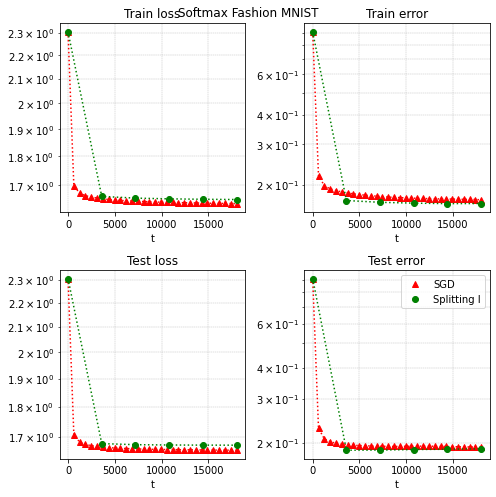

In [44]:
times         = [ts_sgd,           ts_spl]#,           ts_gd[::SKIP_RATE]]
losses_trains = [losses_train_sgd, losses_train_spl]#, losses_train_gd]
losses_tests  = [losses_test_sgd,  losses_test_spl]#,  losses_test_gd]
errors_trains = [errors_train_sgd, errors_train_spl]#, errors_train_gd]
errors_tests  = [errors_test_sgd,  errors_test_spl]#,  errors_test_gd]
title     = 'Softmax Fashion MNIST'

plot_continuous_time_softmax(times, losses_trains, losses_tests, errors_trains, errors_tests, LABELS, title = title)